
Systematic analysis of Degenhart stabilizer performance.


In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import glob
import sys

[sys.path.append(f) for f in glob.glob('utils/*')]
from preprocess import DataStruct, daysBetween
from firingrate import raster2FR
from plotting_utils import *
from lineplots import plotsd
from stabilizer_utils import *
from recalibration_utils import *
from session_utils import *


from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import FactorAnalysis, PCA


files          = glob.glob('D:/T5_ClosedLoop/*')

sessions_check = np.load('misc_data/sessions_check.npy', allow_pickle = True).item()
min_nblocks    = 3
max_ndays      = 14
min_R2         = 0.1

init_pairs    = get_SessionPairs(files, min_nblocks = min_nblocks, max_ndays = max_ndays, manually_remove = sessions_check['bad_days'])
pairs, scores = get_StrongTransferPairs(init_pairs, min_R2 = min_R2, train_frac = 0.5, block_constraints = sessions_check)
n_pairs       = len(pairs)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from copy import deepcopy


# general settings:
np.random.seed(42)
diffs           = list()
task            = None
train_frac      = 0.5
sigma           = None

# subspace stabilizer settings:
model_type      = 'FactorAnalysis'
component_sweep = [1, 2, 4, 6, 8, 10, 12, 14]
B_sweep         = [100, 120, 140, 160, 180, 192]
thresh          = 0.1

# ------------------------------------------------------------

dayA_latentscores = np.zeros((len(component_sweep), n_pairs)) 
dayA_fullscores   = np.zeros((2, n_pairs)) # row 0: full decoder (train), row 1: full decoder (test)

dayB_latentscores = np.zeros((len(component_sweep), len(B_sweep), n_pairs)) 
dayB_fullscores   = np.zeros((3, n_pairs)) # 0: no recalibration, 1: mean recalibration, 2: full recalibration

diffs             = np.zeros((n_pairs, ))

for i, (A_file, B_file) in enumerate(pairs):
    dayA, dayB              = DataStruct(A_file), DataStruct(B_file)
    diffs[i]                = daysBetween(dayA.date, dayB.date) # record number of days between sessions
    
    dayA_blocks             = [sessions_check[A_file] if A_file in sessions_check.keys() else None][0]
    dayB_blocks             = [sessions_check[B_file] if B_file in sessions_check.keys() else None][0] 
    dayA_task, dayB_task, _ = getPairTasks(dayA, dayB, task = task)
    
    # obtain features and cursorError targets:
    Atrain_x, Atest_x, Atrain_y, Atest_y = getTrainTest(dayA, train_frac = train_frac, sigma = sigma, blocks = dayA_blocks, task = dayA_task, return_flattened = True)
    Btrain_x, Btest_x, Btrain_y, Btest_y = getTrainTest(dayB, train_frac = train_frac, sigma = sigma, blocks = dayB_blocks, task = dayB_task, return_flattened = True)
    
    score, full_decoder   = traintest_DecoderSupervised([Atrain_x], [Atrain_x], [Atrain_y], [Atrain_y], meanRecal = False)     # evaluate training set mean performance 
    dayA_fullscores[0, i] = np.mean(score)
    dayA_fullscores[1, i] = traintest_DecoderSupervised([Atrain_x], [Atest_x], [Atrain_y], [Atest_y], meanRecal = False)[0][0]  # evaluate testing set mean performance 
    
    for j, n_components in enumerate(component_sweep):
  
        # fit dimensionality reduction method to train latent decoder:
        stab                         = Stabilizer(model_type, n_components)
        stab.fit_ref(Atrain_x, conditionAveraged = False)
        Atrain_latent, Atest_latent  = stab.ref_model.transform(Atrain_x), stab.ref_model.transform(Atest_x)

        # train and evaluate day A decoders:
        latent_decoder          =  LinearRegression(fit_intercept = False, normalize = False).fit(Atrain_latent - Atrain_latent.mean(axis = 0), Atrain_y)
        dayA_latentscores[j, i] = latent_decoder.score(Atest_latent - Atrain_latent.mean(axis = 0), Atest_y)
        
        # ------ now train and evaluate day B decoder -----------
        

        dayB_fullscores[0, i] = full_decoder.score(Btest_x - Atrain_x.mean(axis = 0), Btest_y)    # no recalibration
        dayB_fullscores[1, i] = full_decoder.score(Btest_x - Btrain_x.mean(axis = 0), Btest_y)    # mean recalibration
        dayB_fullscores[2, i] =  LinearRegression(normalize = False).fit(Btrain_x, Btrain_y).score(Btest_x, Btest_y) # full recalibration
        
        for k, B in enumerate(B_sweep):
            # Stabilizer:
            stab.fit_new(Btrain_x, B = B, thresh = thresh, conditionAveraged = False, conditions = None)
            Btrain_latent, Btest_latent = stab.transform(Btrain_x), stab.transform(Btest_x)
            dayB_latentscores[j, k, i]  = latent_decoder.score(Btest_latent - Btrain_latent.mean(axis = 0), Btest_y)



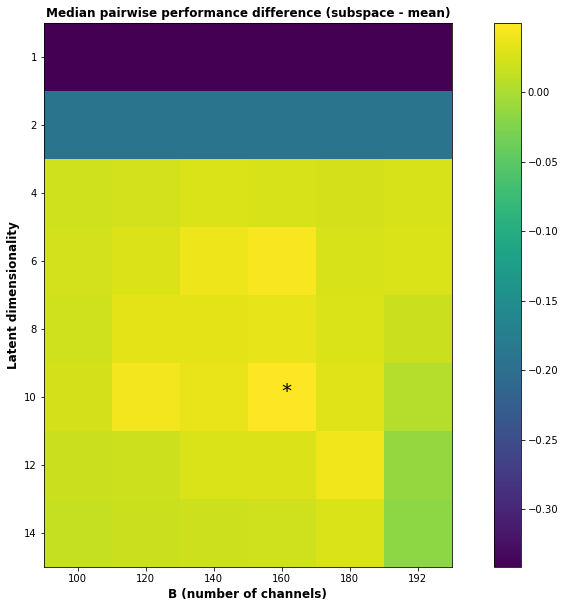

In [16]:
figSize(10, 15)

grid_meanscores = np.median(dayB_latentscores - dayB_fullscores[1, :], axis = 2)
opt_D, opt_B    = np.unravel_index(grid_meanscores.argmax(), grid_meanscores.shape)

plt.imshow(grid_meanscores)
plt.text(opt_B, opt_D, '*', fontsize = 20)
plt.xlabel('B (number of channels)', fontweight = 'bold', fontsize = 12)
plt.ylabel('Latent dimensionality', fontweight = 'bold', fontsize = 12)
plt.title('Median pairwise performance difference (subspace - mean)', fontweight = 'bold')
plt.colorbar()
ax = plt.gca()
_  = ax.set_yticks(np.arange(len(component_sweep)))
_  = ax.set_xticks(np.arange(len(B_sweep)))
_  = ax.set_yticklabels(component_sweep,)
_  = ax.set_xticklabels(B_sweep)

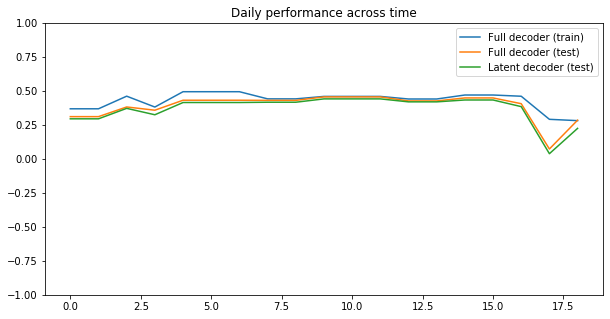

In [17]:
figSize(5, 10)

plt.plot(dayA_fullscores[0, :], label = 'Full decoder (train)')
plt.plot(dayA_fullscores[1, :], label = 'Full decoder (test)')
plt.plot(dayA_latentscores[opt_D, :], label = 'Latent decoder (test)')
plt.title('Daily performance across time')
plt.legend('R^2')
plt.ylim([-1, 1])
plt.legend()


In [18]:
from sklearn.ensemble import BaggingRegressor

n_bootstraps = 500

# get rid of pesky day with giant nonstationarity:
outliers     = np.where(np.abs(dayB_fullscores[1, :]) > 1000 * np.median(np.abs(dayB_fullscores[1, :])))
non_outliers = np.setdiff1d(np.arange(len(diffs)), outliers)

# normalize by fully recalibrated performance on new day (upper limit on performance):
meanrecal_normalized = dayB_fullscores[1, :]# / dayB_fullscores[2, :]
subspace_normalized  = dayB_latentscores[opt_D, opt_B, :] #/ dayB_fullscores[2, :]

# build a bootstrapping model:
bootstrap_meanrecal = BaggingRegressor(LinearRegression(), n_estimators = n_bootstraps, bootstrap = True, random_state = 42)
bootstrap_meanrecal.fit(diffs[non_outliers, np.newaxis], meanrecal_normalized[non_outliers])

bootstrap_subspace = BaggingRegressor(LinearRegression(), n_estimators = n_bootstraps, bootstrap = True, random_state = 42)
bootstrap_subspace.fit(diffs[non_outliers, np.newaxis], subspace_normalized[non_outliers])

BaggingRegressor(base_estimator=LinearRegression(), n_estimators=500,
                 random_state=42)

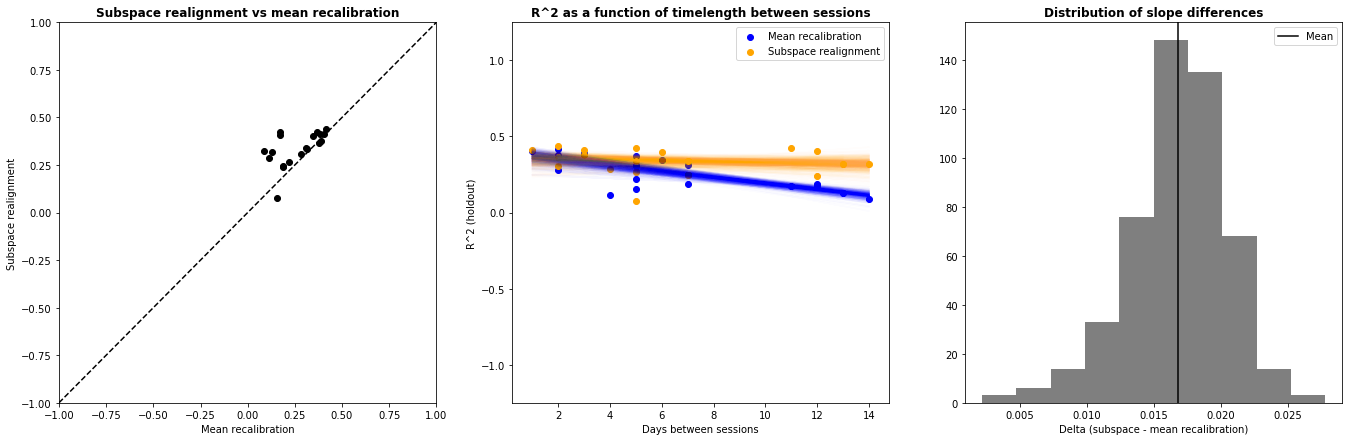

In [19]:
# make some plots, and use bootstrapping to estimate CIs on regression fits:
figSize(7, 23)

plt.subplot(1, 3, 1)
plt.scatter(dayB_fullscores[1, :], dayB_latentscores[opt_D, opt_B, :], color = 'k')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.plot([-1, 1], [-1, 1], color = 'k', linestyle = '--')
plt.title('Subspace realignment vs mean recalibration', fontweight = 'bold')
plt.xlabel('Mean recalibration')
plt.ylabel('Subspace realignment')
#plt.ylim([-1, 1])

plt.subplot(1, 3, 2)
for (meanrecal, subspace) in zip(bootstrap_meanrecal.estimators_, bootstrap_subspace.estimators_):
    plt.plot(diffs[non_outliers], meanrecal.predict(diffs[non_outliers, np.newaxis]), alpha = 0.01, color = 'b')
    plt.plot(diffs[non_outliers], subspace.predict(diffs[non_outliers, np.newaxis]), alpha = 0.01, color = 'orange')

plt.scatter(diffs, meanrecal_normalized, label = 'Mean recalibration', color = 'b')
plt.scatter(diffs, subspace_normalized, label = 'Subspace realignment', color = 'orange')
plt.xlabel('Days between sessions')
plt.ylabel('R^2 (holdout)')
plt.title('R^2 as a function of timelength between sessions', fontweight = 'bold')

plt.ylim([-1.25, 1.25])
plt.legend()

plt.subplot(1, 3, 3)
slope_diffs = np.concatenate([i.coef_ for i in bootstrap_subspace.estimators_])  - np.concatenate([i.coef_ for i in bootstrap_meanrecal.estimators_])
_ = plt.hist(slope_diffs, color = 'k', alpha = 0.5)
plt.title('Distribution of slope differences', fontweight = 'bold')
plt.xlabel('Delta (subspace - mean recalibration)')
plt.axvline(np.mean(slope_diffs), color = 'k', label = 'Mean')
plt.legend()

In [20]:
len(diffs)

19